In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# import numpy as np
# import cv2
# import matplotlib.pyplot as plt
# import os

# images = []


# t_mask = []

# images_path = "/content/drive/MyDrive/projects/origa/images/images"
# mask_path = "/content/drive/MyDrive/projects/origa/manual marking/manual marking"

# filenames = sorted(os.listdir(images_path))
# for file_ in filenames:
#   image_path = os.path.join(images_path,file_)
#   img = cv2.imread(image_path)
#   img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
#   img = cv2.resize(img,(256,256))
#   images.append(img)



#   mask_file = file_.split('.')[0]+".mat"
#   label_path = os.path.join(mask_path,mask_file)

#   mat_data = scipy.io.loadmat(label_path)  # Replace 'your_image_file.mat' with the actual filename

# # Extract the image data from the dictionary
#   image_data = mat_data['mask']
#   image_data = cv2.resize(image_data,(256,256))

#   optic_disk_mask = (image_data == 0).astype(np.uint8)*255 # Convert True/False to 1/0
#   optic_cup_mask = (image_data == 2).astype(np.uint8)*255
#   optic_disk_mask = np.invert(np.array(optic_disk_mask))

#   optic_disk_mask = np.array(optic_disk_mask>125,dtype=np.uint8)
#   optic_cup_mask = np.array(optic_cup_mask>125,dtype=np.uint8)

#   res= np.dstack([optic_disk_mask,optic_cup_mask,optic_disk_mask*optic_cup_mask])


#   t_mask.append(res)

In [4]:
import numpy as np
images = np.load('/content/drive/MyDrive/projects/origa/images.npy')
t_mask = np.load('/content/drive/MyDrive/projects/origa/t_mask.npy')

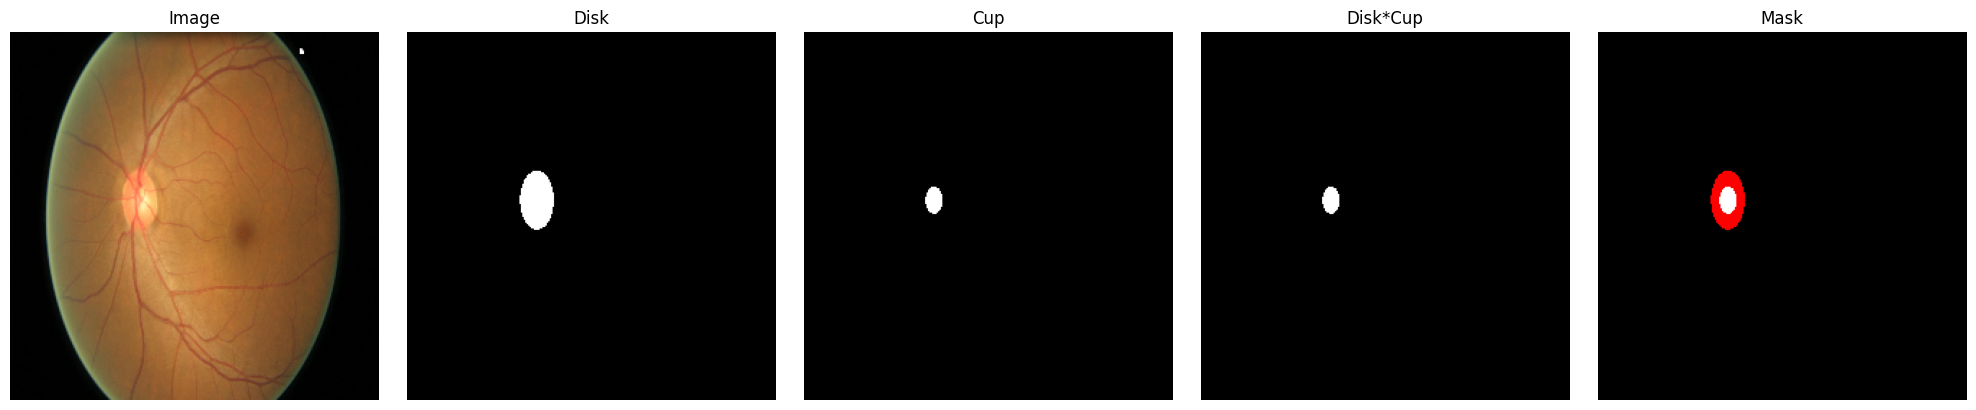

In [5]:
import matplotlib.pyplot as plt

# Assuming images and t_mask are your lists of images and masks

fig, axs = plt.subplots(1, 5, figsize=(20, 4))  # 1 row, 5 columns

axs[0].imshow(images[12])
axs[0].set_title('Image')
axs[0].axis('off')

axs[1].imshow(t_mask[12][:, :, 0] * 255, cmap='gray')
axs[1].set_title('Disk')
axs[1].axis('off')

axs[2].imshow(t_mask[12][:, :, 1] * 255, cmap='gray')
axs[2].set_title('Cup')
axs[2].axis('off')

axs[3].imshow(t_mask[12][:, :, 2] * 255, cmap='gray')
axs[3].set_title('Disk*Cup')
axs[3].axis('off')

axs[4].imshow(t_mask[12] * 255, cmap='gray')
axs[4].set_title('Mask')
axs[4].axis('off')

plt.tight_layout()
plt.show()


In [6]:
images[2].shape

(256, 256, 3)

In [7]:
t_mask[2].shape

(256, 256, 3)

In [8]:
images = np.array(images)
t_mask = np.array(t_mask)

In [9]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(images,t_mask,test_size=0.1,random_state=42)

In [10]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((518, 256, 256, 3), (58, 256, 256, 3), (518, 256, 256, 3), (58, 256, 256, 3))

In [11]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Activation, Dense, Permute, Multiply, Add
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, Dense, multiply, add


def residual_block(inputs, filters, kernel_size):
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    residual = x
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    # residual = tf.keras.layers.Conv2D(filters, (1, 1), padding='same')(inputs)  # Match dimensions for addition
    # residual = tf.keras.layers.BatchNormalization()(residual)
    outputs = tf.keras.layers.add([x, residual])
    outputs = tf.keras.layers.ReLU()(outputs)
    return outputs

def conv(inputs, filters, kernel_size):
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    return x

def unet_model(input_shape=(256, 256, 3)):
    
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    encoder_conv1 = conv(inputs, filters=16, kernel_size=(3, 3))
    print('encoder_conv1 :', encoder_conv1.shape)
    encoder_pool1 = layers.MaxPooling2D(pool_size=(2, 2))(encoder_conv1)

    encoder_conv2 = conv(encoder_pool1, filters=32, kernel_size=(3, 3))
    print('encoder_conv2 :', encoder_conv2.shape)
    encoder_pool2 = layers.MaxPooling2D(pool_size=(2, 2))(encoder_conv2)

    encoder_conv3 = conv(encoder_pool2, filters=64, kernel_size=(3, 3))
    print('encoder_conv3 :', encoder_conv3.shape)
    encoder_pool3 = layers.MaxPooling2D(pool_size=(2, 2))(encoder_conv3)

    encoder_conv4 = conv(encoder_pool3, filters=128, kernel_size=(3, 3))
    print('encoder_conv4 :', encoder_conv4.shape)
    encoder_pool4 = layers.MaxPooling2D(pool_size=(2, 2))(encoder_conv4)

    #Center

    bottle = conv(encoder_pool4, filters=256, kernel_size=(3, 3))
    print('bottle :', bottle.shape)

    # Decoder
    decoder_up4 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(bottle)
    decoder_up4 = layers.concatenate([encoder_conv4, decoder_up4], axis=3)
    print(decoder_up4.shape)
    decoder_conv5 = conv(decoder_up4, filters=128, kernel_size=(3, 3))


    decoder_up3 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(decoder_conv5)
    decoder_up3 = layers.concatenate([encoder_conv3, decoder_up3], axis=3)
    print(decoder_up3.shape)
    decoder_conv6 = conv(decoder_up3, filters=64, kernel_size=(3, 3))

    decoder_up2 = layers.Conv2DTranspose(32, 2, strides=(2, 2), padding='same')(decoder_conv6)
    decoder_up2 = layers.concatenate([encoder_conv2, decoder_up2], axis=3)
    print(decoder_up2.shape)
    decoder_conv7 = conv(decoder_up2, filters=32, kernel_size=(3, 3))

    decoder_up1 = layers.Conv2DTranspose(16, 2, strides=(2, 2), padding='same')(decoder_conv7)
    decoder_up1 = layers.concatenate([encoder_conv1, decoder_up1], axis=3)
    print(decoder_up1.shape)
    decoder_conv8 = conv(decoder_up1, filters=16, kernel_size=(3, 3))

    # Output layer
    outputs = layers.Conv2D(3, 1, activation='sigmoid')(decoder_conv8)
    print(outputs.shape)

    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

# Create an instance of the UNeXt model
model = unet_model()
model.summary()


encoder_conv1 : (None, 256, 256, 16)
encoder_conv2 : (None, 128, 128, 32)
encoder_conv3 : (None, 64, 64, 64)
encoder_conv4 : (None, 32, 32, 128)
bottle : (None, 16, 16, 256)
(None, 32, 32, 128)
(None, 64, 64, 64)
(None, 128, 128, 32)
(None, 256, 256, 16)
(None, 256, 256, 3)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 16)         64        ['conv2d[0][0]']              
 Normalization)  

In [19]:
import numpy as np
import tensorflow as tf
from keras import backend as K
from keras.losses import binary_crossentropy

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15

def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision=(true_positives / (predicted_positives + K.epsilon()))
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [21]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_disk_1.h5',monitor='val_dice_coef',verbose=1,save_best_only=True)

In [22]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
]

In [23]:
opt =tf.keras.optimizers.Adam(learning_rate=0.0005 )
model.compile(optimizer=opt, loss = 'binary_crossentropy', metrics=["binary_accuracy",iou,dice_coef,precision,f1_score])

#training

In [ ]:
# model.load_weights('/content/drive/MyDrive/projects/weights/UNet(1)_ORIGA_50_epochs.h5')

In [24]:
results = model.fit(x_train,y_train,validation_split=0.1,batch_size = 8,epochs=50,callbacks=callbacks)

Epoch 1/50
59/59 [==============================] - 37s 188ms/step - loss: 0.3714 - binary_accuracy: 0.9576 - iou: 0.0221 - dice_coef: 0.0432 - precision: 0.3825 - f1_score: 0.4547 - val_loss: 0.8417 - val_binary_accuracy: 0.6550 - val_iou: 0.0161 - val_dice_coef: 0.0316 - val_precision: 0.0243 - val_f1_score: 0.0473
Epoch 2/50
59/59 [==============================] - 5s 89ms/step - loss: 0.2472 - binary_accuracy: 0.9968 - iou: 0.0318 - dice_coef: 0.0616 - precision: 0.8310 - f1_score: 0.8224 - val_loss: 0.5228 - val_binary_accuracy: 0.8615 - val_iou: 0.0229 - val_dice_coef: 0.0448 - val_precision: 0.0614 - val_f1_score: 0.1153
Epoch 3/50
59/59 [==============================] - 5s 85ms/step - loss: 0.1907 - binary_accuracy: 0.9974 - iou: 0.0405 - dice_coef: 0.0778 - precision: 0.8778 - f1_score: 0.8570 - val_loss: 0.2971 - val_binary_accuracy: 0.9686 - val_iou: 0.0355 - val_dice_coef: 0.0686 - val_precision: 0.2295 - val_f1_score: 0.3710
Epoch 4/50
59/59 [=============================

In [25]:
model.save_weights('/content/drive/MyDrive/projects/weights/UNet(1)_ORIGA_50_epochs.h5')

In [26]:
model.load_weights('/content/drive/MyDrive/projects/weights/UNet(1)_ORIGA_50_epochs.h5')

1/1 [==============================] - 2s 2s/step


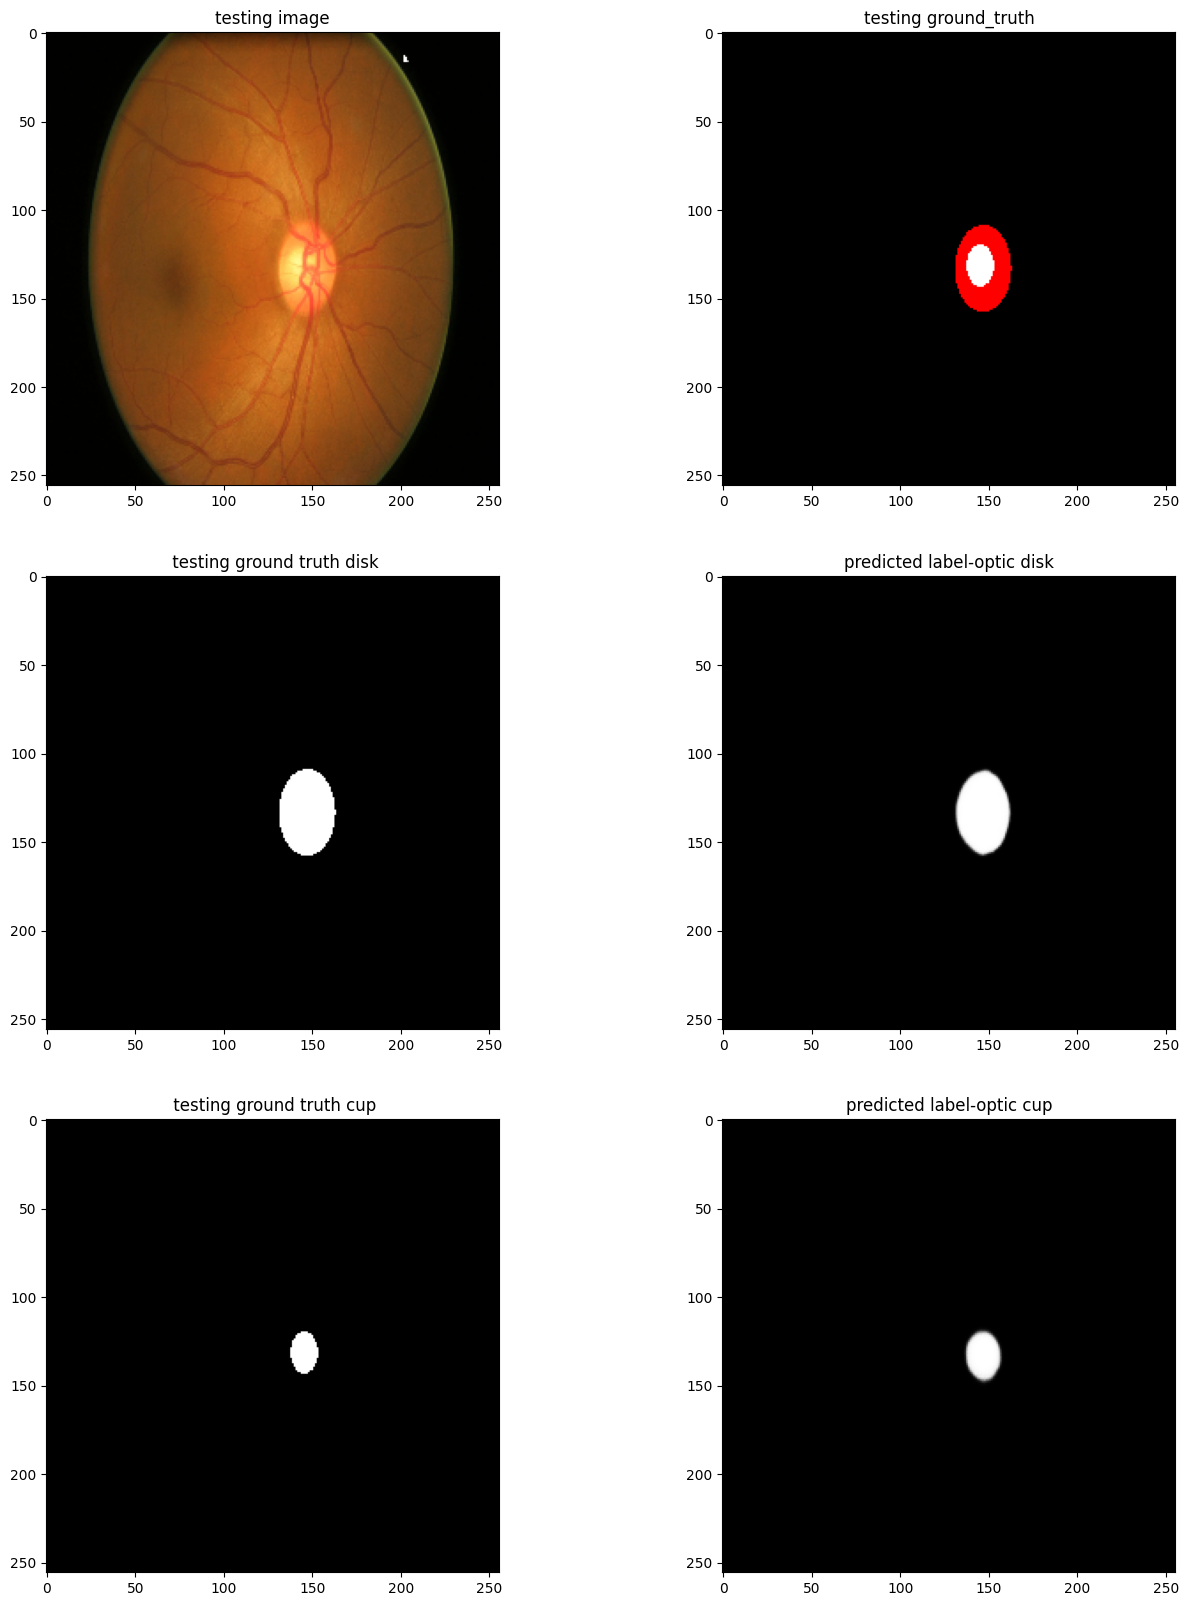

In [27]:
# xtest
test_img = x_test[11]
ground_truth = y_test[11]

test_img_input = np.expand_dims(test_img,0)


#print(test_img_input.shape)
predection = model.predict(test_img_input)
pred = np.array(predection)
grd = np.array(ground_truth)
plt.figure(figsize=(16,20))

plt.subplot(321)
plt.title("testing image")
plt.imshow(test_img_input[0])

plt.subplot(322)
plt.title("testing ground_truth")
plt.imshow(grd*255,cmap="gray")


plt.subplot(323)
plt.title(" testing ground truth disk")
plt.imshow(grd[:,:,0]*255,cmap="gray")

plt.subplot(325)
plt.title(" testing ground truth cup")
plt.imshow(grd[:,:,1]*255,cmap="gray")

plt.subplot(324)
plt.title("predicted label-optic disk")
plt.imshow(pred[0][:,:,0]*255,cmap="gray")

plt.subplot(326)
plt.title("predicted label-optic cup")
plt.imshow(pred[0][:,:,1]*255,cmap="gray")


In [28]:
import numpy as np

# Assuming x_test contains all the images to be predicted
# Print the shape of x_test to understand its structure
print("Shape of x_test:", x_test.shape)

# Print the data type of x_test elements to understand the type of data
print("Data type of elements in x_test:", x_test.dtype)


Shape of x_test: (58, 256, 256, 3)
Data type of elements in x_test: uint8


In [29]:
import numpy as np
from keras.models import load_model

# # Load the model
# model = load_model('model.h5')

# Assuming x_test contains all the images to be predicted
# x_test.shape = (58, 256, 256, 3)
# Predict masks for all images in x_test
y_pred = model.predict(x_test)

# Assuming binary classification, apply threshold
y_pred = (y_pred > 0.5).astype(np.uint8)  #binary

# Now y_pred_binary contains all the predicted masks for the images in x_test
# You can further process or save them as needed


2/2 [==============================] - 8s 4s/step


In [30]:
y_pred = np.array(y_pred)

In [31]:
np.unique(y_pred)

array([0, 1], dtype=uint8)

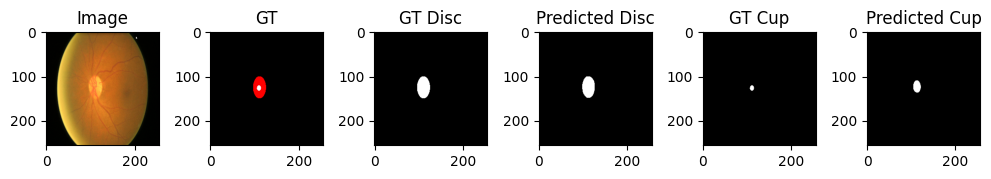

In [47]:
import matplotlib.pyplot as plt

i = 15

# Plot the images in 3 rows and 2 columns
plt.figure(figsize=(10, 15))

# Original Image
plt.subplot(1, 6, 1)
plt.imshow(x_test[i], cmap='gray')
plt.title("Image")

# Ground Truth
plt.subplot(1, 6, 2)
plt.imshow(y_test[i]*255, cmap='gray')
plt.title("GT")

# Ground Truth Mask - Disc
plt.subplot(1, 6, 3)
plt.imshow(y_test[i][:, :, 0], cmap='gray')
plt.title("GT Disc")

# Predicted Mask - Disc
plt.subplot(1, 6, 4)
plt.imshow(y_pred[i][:, :, 0], cmap='gray')
plt.title("Predicted Disc")

# Ground Truth Mask - Cup
plt.subplot(1, 6, 5)
plt.imshow(y_test[i][:, :, 1], cmap='gray')
plt.title("GT Cup")

# Predicted Mask - Cup
plt.subplot(1, 6, 6)
plt.imshow(y_pred[i][:, :, 1], cmap='gray')
plt.title("Predicted Cup")

plt.tight_layout()
plt.show()


In [41]:
i_no = '527'
img_path= os.path.join('/content/drive/MyDrive/projects/origa/images/images',i_no+".jpg")
img = cv2.imread(img_path)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(256,256))


1/1 [==============================] - 0s 95ms/step


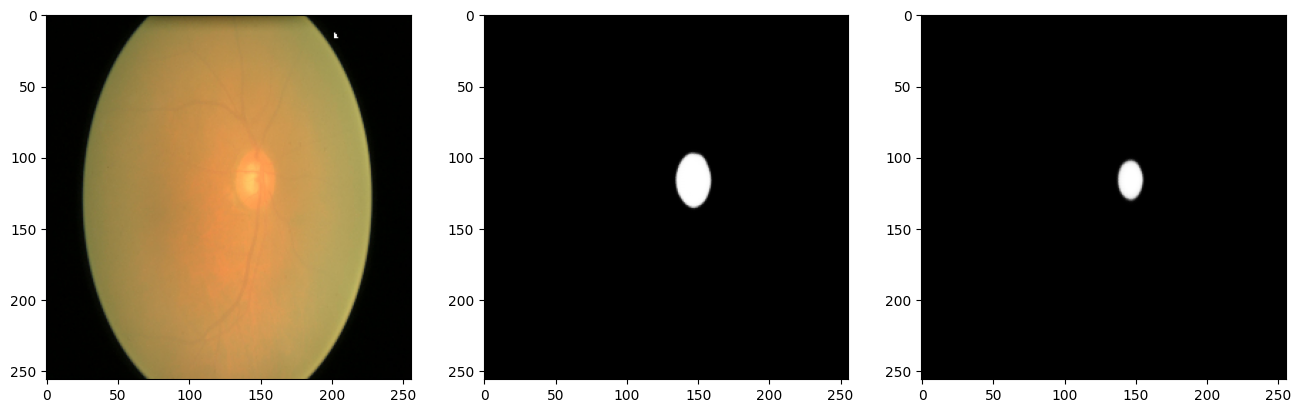

In [42]:
fundus_img = img

test_img_input1 = np.expand_dims(fundus_img, 0)
predection1 = model.predict(test_img_input1)
pred1 = np.array(predection1)
plt.figure(figsize=(16,5))
plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
plt.imshow(pred1[0][:,:,0],cmap='gray')
plt.subplot(133)
plt.imshow(pred1[0][:,:,1],cmap='gray')

1/1 [==============================] - 0s 29ms/step


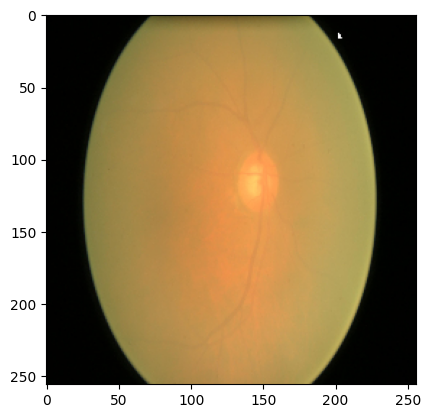

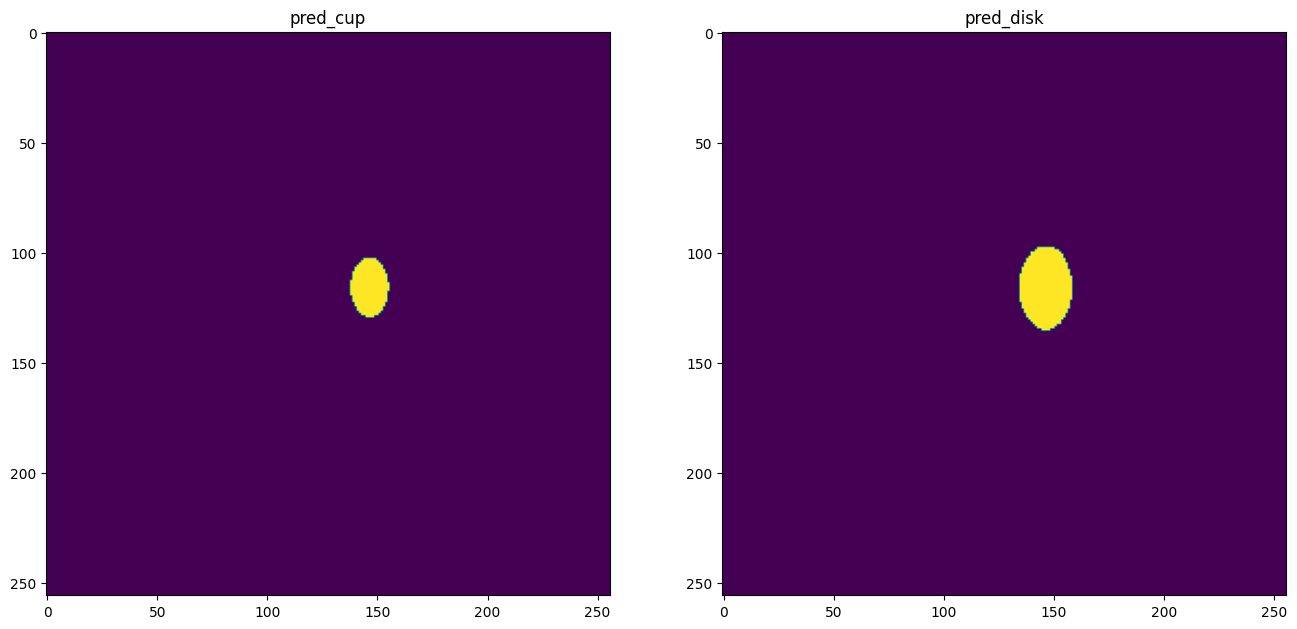

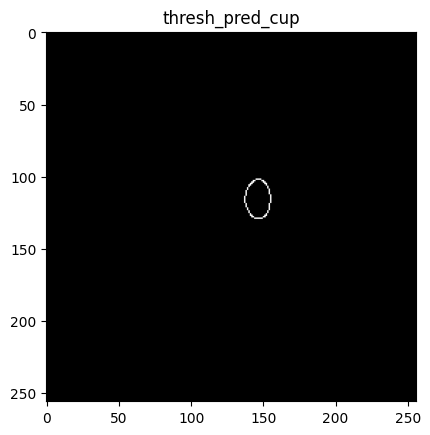

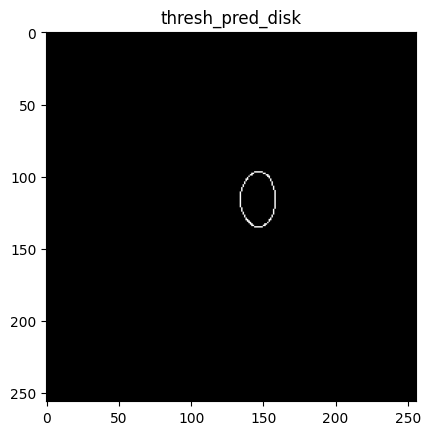

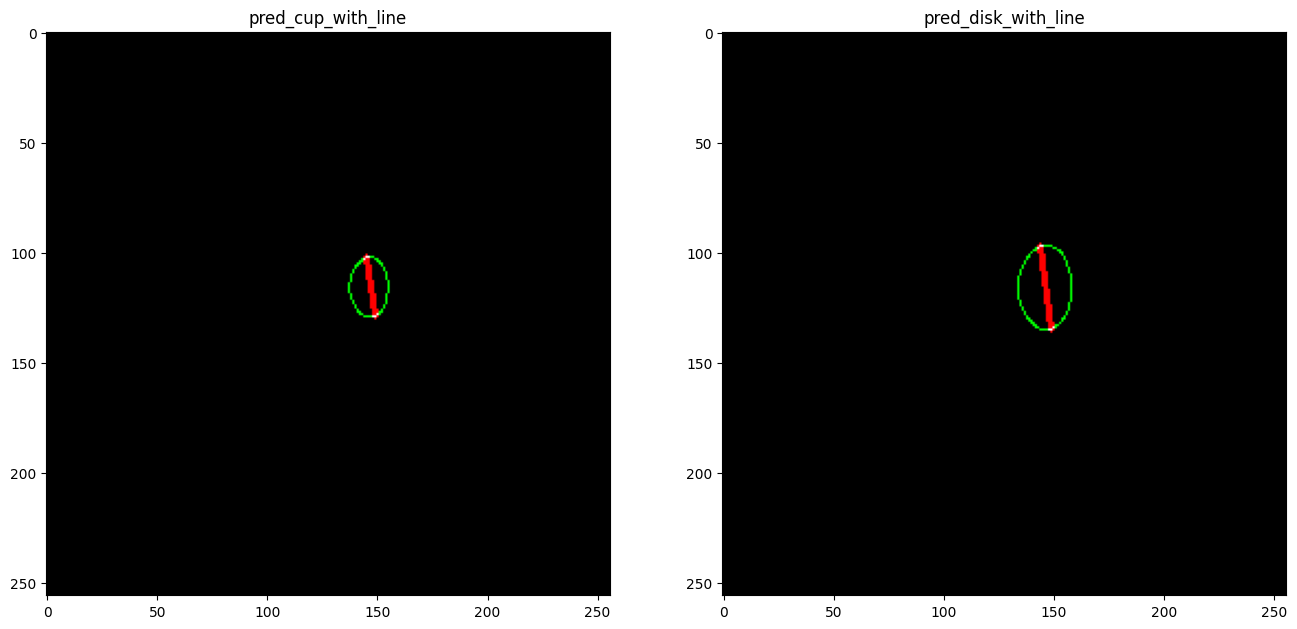

Maximum distance between white pixels in pred cup: 27.294688127912362 pixels
Maximum distance between white pixels in pred disk: 38.3275357934736 pixels


In [43]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def process_image(img):
    edges = cv2.Canny(img, 100, 200)
    ret, thresh = cv2.threshold(edges, 0, 1, cv2.THRESH_BINARY)
    return thresh

def find_contour_and_max_distance(thresh):
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = max(contours, key=cv2.contourArea)
    max_distance, points = calculate_max_distance(contour)
    return contour, max_distance, points

def calculate_max_distance(contour):
    max_distance = 0
    max_distance_points = (0, 0), (0, 0)
    for i in range(len(contour)):
        for j in range(i + 1, len(contour)):
            distance = np.linalg.norm(contour[i][0] - contour[j][0])
            if distance > max_distance:
                max_distance = distance
                max_distance_points = tuple(contour[i][0]), tuple(contour[j][0])
    return max_distance, max_distance_points

def visualize_results(image_with_line, title):
    image_with_line = cv2.cvtColor(image_with_line, cv2.COLOR_BGR2GRAY)
    image_with_line = np.array(image_with_line > 125, dtype=np.uint8)
    res = np.dstack([image_with_line, thresh, image_with_line * thresh])
    plt.title(title)
    plt.imshow(res * 255)

# Original code

fundus_img = img

test_img_input1 = np.expand_dims(fundus_img, 0)
predection1 = model.predict(test_img_input1)
pred1 = np.array(predection1)
pred_cup = np.array(pred1[0][:, :, 1] > 0.5, dtype=np.uint8)
pred_disk = np.array(pred1[0][:, :, 0] > 0.5, dtype=np.uint8)

# Plot original images
plt.imshow(fundus_img)
plt.show()
plt.figure(figsize=(16, 8))


plt.subplot(121)
plt.title("pred_cup")
plt.imshow(pred_cup)
plt.subplot(122)
plt.title("pred_disk")
plt.imshow(pred_disk)
plt.show()



# Thresholding and edge detection

pred_cup = pred_cup * 255
pred_disk = pred_disk * 255


thresh_pred_cup = process_image(pred_cup)
thresh_pred_disk = process_image(pred_disk)

# Display thresholded images

plt.show()
plt.title("thresh_pred_cup")
plt.imshow(thresh_pred_cup * 255, cmap='gray')
plt.show()
plt.title("thresh_pred_disk")
plt.imshow(thresh_pred_disk * 255, cmap='gray')
plt.show()

# Find contours and calculate max distances

pred_cup_contour, max_pred_cup_distance, pred_cup_points = find_contour_and_max_distance(thresh_pred_cup)
pred_disk_contour, max_pred_disk_distance, pred_disk_points = find_contour_and_max_distance(thresh_pred_disk)

# Draw lines on images
def draw_lines(image_with_line, points):
    cv2.line(image_with_line, points[0], points[1], (0, 255, 0), 2)
    return image_with_line

# Add missing variable definitions

pred_cup_with_line = draw_lines(cv2.cvtColor(thresh_pred_cup, cv2.COLOR_GRAY2BGR), pred_cup_points)
pred_disk_with_line = draw_lines(cv2.cvtColor(thresh_pred_disk, cv2.COLOR_GRAY2BGR), pred_disk_points)

# Modify the visualize_results function
def visualize_results(image_with_line, title, thresh):
    image_with_line = cv2.cvtColor(image_with_line, cv2.COLOR_BGR2GRAY)
    image_with_line = np.array(image_with_line > 125, dtype=np.uint8)
    res = np.dstack([image_with_line, thresh, image_with_line * thresh])
    plt.title(title)
    plt.imshow(res * 255)

# Visualize results with lines
plt.figure(figsize=(16, 8))


plt.subplot(1, 2, 1)
visualize_results(pred_cup_with_line, 'pred_cup_with_line', thresh_pred_cup)



plt.subplot(1, 2, 2)
visualize_results(pred_disk_with_line, 'pred_disk_with_line', thresh_pred_disk)

plt.show()



# Print maximum distances

print(f"Maximum distance between white pixels in pred cup: {max_pred_cup_distance} pixels")
print(f"Maximum distance between white pixels in pred disk: {max_pred_disk_distance} pixels")



In [44]:
cdr1 = max_pred_cup_distance/max_pred_disk_distance

In [45]:
#Finding the Details from Excel sheet

import pandas as pd

# Assuming df is your DataFrame containing the data
# Read the Excel file into a DataFrame
df = pd.read_excel("/content/drive/MyDrive/projects/origa/manual_labels.xlsx")

# Clean up the filenames
df['filename'] = df['filename'].str.strip().str.strip("'")

def get_info_for_filename(filename):
    # Look up information for the given filename
    result = df[df['filename'] == filename]

    if not result.empty:
        # Extract relevant information
        eye_value = result['Eye(right=OD, left=OS)'].values[0]
        cdr_value = result['Expert CDR'].values[0]
        set_value = result['set'].values[0]
        diagnosis_value = result['diagnosis(glaucoma=True)'].values[0]

        # Print the information
        print(f"Filename: {filename}")
        print(f"Eye(right=OD, left=OS): {eye_value}")
        print(f"CDR Value: {cdr_value} ,predicted CDR: {cdr1}")
        print(f"Set Value: {set_value}")
        print(f"Diagnosis: {diagnosis_value}")
        print(f'difference={cdr_value-cdr1}')
    else:
        print(f"Filename '{filename}' not found in the dataset.")

# Example: Replace '001.jpg' with the desired filename
get_info_for_filename(i_no+'.jpg')

Filename: 527.jpg
Eye(right=OD, left=OS): OD
CDR Value: 0.7035 ,predicted CDR: 0.712143047102968
Set Value: B
Diagnosis: False
difference=-0.008643047102968038
